In [80]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
words = open('/content/drive/MyDrive/names.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [82]:
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}
vocab_size = len(s2i)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [83]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [84]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = s2i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train,  Y_train  = build_dataset(words[:n1])     # 80%
X_val, Y_val = build_dataset(words[n1:n2])   # 10%
X_test,  Y_test  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [85]:
for x,y in zip(X_train[:20], Y_train[:20]):
  print(''.join(i2s[ix.item()] for ix in x), '-->', i2s[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
# @title manual_Initialize
# n_embd = 10
# n_hidden = 64
# block_size = 3
# vocab_size = len(s2i)

# g = torch.Generator().manual_seed(2147483647)
# C  = torch.randn((vocab_size, n_embd),                   generator=g)
# W1 = torch.randn((n_embd*block_size, n_hidden),          generator=g) * ((5/3)/(n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden,                               generator=g) * 0.1
# W2 = torch.randn((n_hidden, vocab_size),                 generator=g) * 0.1
# b2 = torch.randn(vocab_size,                             generator=g) * 0.1

# bngain = torch.randn((1,n_hidden)) * 0.1 + 1.0
# bnbias = torch.randn((1,n_hidden)) * 0.1

# bnmean_running = torch.zeros((1, n_hidden)) # initialize 0 mean
# bnstd_running = torch.ones((1, n_hidden)) # initialize 1 std

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# print(sum(p.nelement() for p in parameters))
# for p in parameters:
#   p.requires_grad = True
#   print(p.shape)

In [86]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2: # fixing batch-norm mean over multiple dimensions issue  !!!!pytorch BatchNorm1D implements this another way. We did (N,L,C), pytorch expects(N,C,L)!!!
        dim = 0 # if input is 2-d then 0th dim is the batch, and mean over 0
      elif x.ndim == 3:
        dim = (0,1) # if input is 3-d then 0th,1st dim is the batch and mini-batch of embedding, and mean over (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar  = x.var(dim, keepdim=True, unbiased=True) # batch variance
    else:
      xmean = self.running_mean
      xvar  = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar+self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var  = (1-self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]
#-----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n # n represents how we want to divide each rows of every batch
               # for bigram n=2, for trigram n=2,
               # block_size=8-> 1 2 3 4 5 6 7 8 -> (1 2)(3 4)(5 6)(7 8) for n=2
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []
#-----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]
#-----------------------------------------------------------------------------------------------


In [96]:
torch.manual_seed(42);

In [97]:
n_embd = 24
n_hidden = 128
block_size = 8
vocab_size = len(s2i)

# now Embedding #C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # make last layer less confident

  # for layer in model.layers[:-1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad =True


76579


In [ ]:
'''
Pytorch containers will replace our layers list implementation. Like torch.containers.sequential will store all inputs in a sequential manner
'''

In [70]:
ix = torch.randint(0, X_train.shape[0], (4,))
Xb, Yb = X_train[ix], Y_train[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':' ,tuple(layer.out.shape) )

In [77]:
# @title #####bugged batchnorm
e = torch.randn(32,4,68)
emean = e.mean(0, keepdim=True) # 1 4 68
evar = e.var(0, keepdim=True) # 1 4 68
ehat = (e - emean)/torch.sqrt(evar+1e-5) # 32 4 68
print(ehat.shape, emean.shape)
model.layers[3].running_mean.shape

torch.Size([32, 4, 68]) torch.Size([1, 4, 68])


torch.Size([1, 4, 68])

In [79]:
# @title ######fixed batchnorm
e = torch.randn(32,4,68)
emean = e.mean((0,1), keepdim=True) # 1 1 68
evar = e.var((0,1), keepdim=True) # 1 1 68
ehat = (e - emean)/torch.sqrt(evar+1e-5) # 32 4 68
print(ehat.shape, emean.shape)
#model.layers[3].running_mean.shape

torch.Size([32, 4, 68]) torch.Size([1, 1, 68])


torch.Size([1, 4, 68])

In [ ]:
# the running_mean when our input/emb were (32,68*4) was just [1,68*4] which is the mean over all 32 examples in a batch.
# but we changed the embedding representation of each batch and the dimension became (32,4,68) but previous implementation
# of batchnorm1d will [1,4,68] instead of [1,4*68],
# thus we are maintaining the statistics for each individual mini-batches(e,g, (1 2)(3 4)(5 6)(7 8))

# instead we want to mean accross a batch direction say (0,1)->where mean will be done on 0th and 1st dim

In [99]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb, Yb = X_train[ix], Y_train[ix]

  # forward pass
  x = Xb
  logits = model(x)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i<150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8805
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


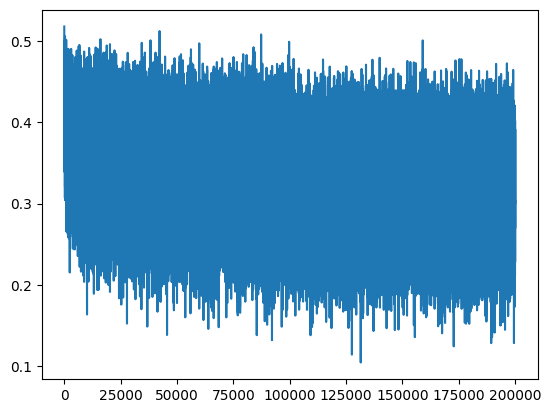

In [ ]:
plt.plot(lossi)

In [ ]:
torch.tensor(lossi).view(-1,1000).shape

torch.Size([200, 1000])

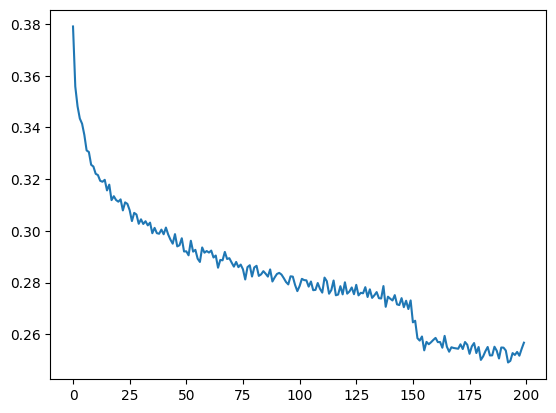

In [100]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1)) # fixing the lossi plot to look nicer

In [101]:
for layer in model.layers:
  layer.training = False

In [102]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690284252166748
val 1.9936527013778687


In [ ]:
'''
wavenet batchnorm fix, 76579 parameters
train 1.7690284252166748
val 1.9936527013778687
wavenet naive with batchnorm bug-fix
train 1.911011815071106
val 2.020193338394165
wavenet naive without batchnorm bug-fix
train 1.9163435697555542
val 2.034247875213623
'''

In [104]:
# # sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(i2s[i] for i in out)) # decode and print the generated word

kharson.
anabella.
harlee.
mangels.
leamir.
benu.
swayde.
jamyly.
zaniya.
hadyya.
jamilyn.
calissa.
gresling.
zhyana.
aovene.
amirs.
jocelen.
yuvin.
uri.
ayomix.


In [ ]:
# sample from the model
'''
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])]
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(i2s[i] for i in out)) # decode and print the generated word
'''

Next Time:
Why Convulations? Brief preview

In [107]:
for x,y in zip(X_train[7:15], Y_train[7:15]):
  print(''.join(i2s[ix.item()] for ix in x), '---->', i2s[y.item()])

........ ----> d
.......d ----> i
......di ----> o
.....dio ----> n
....dion ----> d
...diond ----> r
..diondr ----> e
.diondre ----> .


In [105]:
# forward a single example
logits = model(X_train[[7]])
logits.shape

torch.Size([1, 27])

In [106]:
X_train[7].shape, X_train[[7]].shape

(tensor([0, 0, 0, 0, 0, 0, 0, 0]), tensor([[0, 0, 0, 0, 0, 0, 0, 0]]))

In [108]:
# forward all of them
logits = torch.zeros(8,27) # preallocating memories
for i in range(8):
  logits[i] = model(X_train[[7+i]])
logits.shape

# this is 8 independent calls to our model.
# what convulation will allow us to do is slide this model efficiently over the input sequence,
# this allows the for loop to be done inside kernels and CUDA
# and allows to not explicitly use for loop to call the model, rather hides the for loop inside convulation operation

torch.Size([8, 27])

In [ ]:
# convulation is a "for loop"
# allows us to forward Linear layers efficiently over space